# Deep Learning: Rooms of a House

In [71]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [72]:
import os
from fastai.imports import *
from fastai.conv_learner import *
from fastai.plots import *

In [73]:
PATH = 'dl-rooms/data/'
TRAIN = f'{PATH}train/'
# TEST = f'{PATH}test/'
LABELS = f'{PATH}labels.csv'
arch = resnet50

## 1 Initial Data Exploration

In [74]:
!ls {PATH}

labels.csv  models  test  tmp  train


In [75]:
!ls {TRAIN}

bathroom  bedroom  dining_room	kitchen  living_room  office


In [77]:
os.listdir(TRAIN)

['bedroom', 'bathroom', 'office', 'kitchen', 'dining_room', 'living_room']

In [78]:
data = []
for folder in os.listdir(TRAIN):
    for image in os.listdir(f'{TRAIN}{folder}'):
        data.append({
            'file': f'{folder}/{image}',
            'room_name': folder
        })

In [79]:
data

[{'file': 'bedroom/019.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/052.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/025.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/004.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/023.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/037.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/056.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/046.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/048.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/029.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/007.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/026.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/053.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/059.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/057.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/015.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/022.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/028.jpg', 'room_name': 'bedroom'},
 {'file': 'bedroom/050.jpg',

In [80]:
labels_df = pd.DataFrame(data, columns=['file', 'room_name'])

In [81]:
labels_df.head()

,file,room_name
0,bedroom/019.jpg,bedroom
1,bedroom/052.jpg,bedroom
2,bedroom/025.jpg,bedroom
3,bedroom/004.jpg,bedroom
4,bedroom/023.jpg,bedroom


In [82]:
labels_df.to_csv(LABELS, index=False)

In [83]:
n = len(list(open(LABELS))) - 1
val_idxs = get_cv_idxs(n)

In [84]:
sz = 224
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', LABELS, val_idxs=val_idxs, tfms=tfms)

In [85]:
fname = PATH + data.trn_ds.fnames[0]; fname

'dl-rooms/data/train/bedroom/052.jpg'

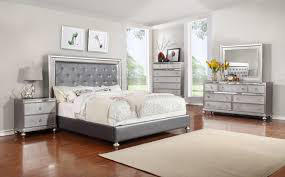

In [86]:
img = PIL.Image.open(fname); img

In [87]:
size_dict = { k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames }

In [88]:
row_sz, col_sz = list(zip(*size_dict.values()))

In [89]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([ 42.,  23.,  55.,  60., 116.,  59.,   7.,   3.,   5.,   2.]),
 array([159. , 186.2, 213.4, 240.6, 267.8, 295. , 322.2, 349.4, 376.6, 403.8, 431. ]),
 <a list of 10 Patch objects>)

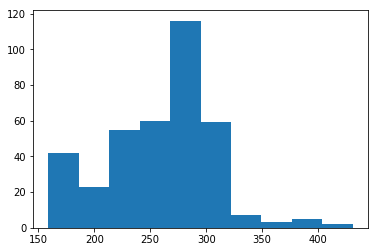

In [90]:
plt.hist(row_sz[row_sz<1500])

(array([  6.,   9.,  43.,  67., 135.,  21.,  53.,   3.,  19.,  16.]),
 array([111., 128., 145., 162., 179., 196., 213., 230., 247., 264., 281.]),
 <a list of 10 Patch objects>)

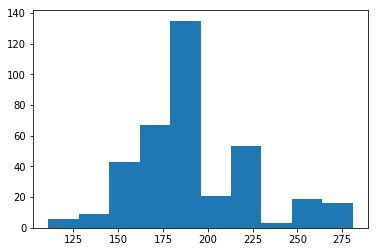

In [91]:
plt.hist(col_sz[col_sz<1500])

In [92]:
np.median(row_sz), np.median(col_sz)

(270.0, 183.0)

## 2 Initial Model

In [93]:
def get_data(sz, bs=64):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'train', LABELS, val_idxs=val_idxs, tfms=tfms)

### 2.1 Precompute

In [94]:
sz = 224
bs = 8
data = get_data(sz, bs)

In [160]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [96]:
lrf = learn.lr_find2()

 50%|█████     | 3/6 [00:00<00:00, 25.56it/s, loss=2.65] 


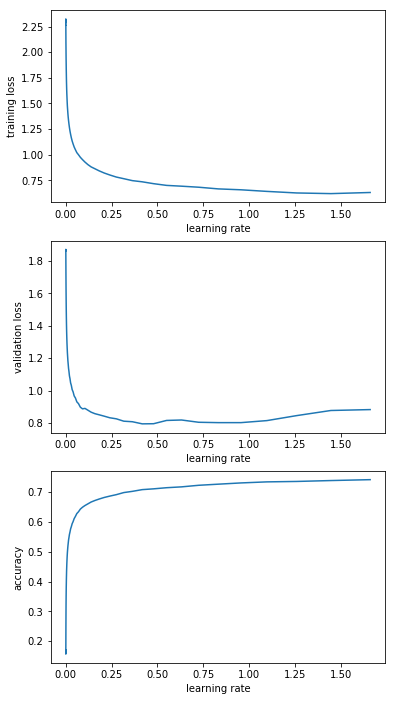

In [97]:
learn.sched.plot()

In [100]:
learn.fit(1e-2, 10)

epoch      trn_loss   val_loss   accuracy       
    0      1.812184   1.112639   0.634409  
    1      1.104346   0.522083   0.817204       
    2      0.799601   0.355975   0.860215        
    3      0.614969   0.318759   0.860215                
    4      0.485716   0.307946   0.88172         
    5      0.401973   0.307355   0.892473        
    6      0.340631   0.305752   0.88172         
    7      0.2957     0.299162   0.88172         
    8      0.262982   0.292846   0.88172         
    9      0.236479   0.289794   0.88172         



[array([0.28979]), 0.8817204243393355]

In [138]:
learn.precompute = False

In [102]:
learn.save('224_pre_last_layer')

In [107]:
learn.load('224_pre_last_layer')

### 2.2 Data Augmentation

In [161]:
learn.precompute = False

In [108]:
learn.fit(1e-3, 5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.98674    0.330055   0.892473  
    1      1.020451   0.363729   0.913978                
    2      1.04185    0.402275   0.892473               
    3      1.039827   0.381287   0.892473               
    4      0.996088   0.371822   0.892473                
    5      0.963667   0.364943   0.892473                
    6      0.957447   0.36734    0.903226                
    7      0.921021   0.35019    0.892473                
    8      0.912063   0.347526   0.892473                
    9      0.894321   0.348649   0.903226                
    10     0.885103   0.33655    0.892473                
    11     0.855667   0.329462   0.892473                
    12     0.845591   0.338899   0.892473                
    13     0.832535   0.339062   0.892473                
    14     0.820355   0.337893   0.903226                
    15     0.804556   0.33623    0.903226                
    16     0.798574   0.341519

[array([0.31907]), 0.9032258006834215]

In [109]:
learn.save('224_pre_last_layer_with_data_aug')

In [170]:
learn.load('224_pre_last_layer_with_data_aug')

In [171]:
learn.unfreeze()

In [172]:
lr = 1e-2
lrs = [lr/100, lr/10, lr]

In [173]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.958827   0.331822   0.870968  
    1      0.916273   0.388364   0.870968                
    2      0.798195   0.38114    0.870968                
    3      0.723608   0.352961   0.88172                 
    4      0.664415   0.288267   0.913978                
    5      0.599855   0.27543    0.913978                
    6      0.542564   0.301946   0.903226                



[array([0.30195]), 0.9032258064516129]

In [186]:
learn.fit(1e-3/3, 3, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.264905   0.235637   0.913978  
    1      0.250759   0.228546   0.924731                
    2      0.240382   0.227737   0.924731                
    3      0.216045   0.232025   0.913978                
    4      0.208595   0.230633   0.913978                
    5      0.207512   0.229152   0.913978                



[array([0.22915]), 0.9139784946236559]

In [187]:
learn.save('224_all_layers')